In [6]:
import graphlearning as gl
import numpy as np
import matplotlib.pyplot as plt
import sklearn.datasets as datasets
import time
import matplotlib.colors as colors


# Статистика и графики
# Для заданного колличетсва точек, список номеров моделей данных, список номеров моделей обучения, список колличества меток в каждом классе. 
Эксперимент проводится N раз
Строит 
1)  результат классификации 2 классов (среднее значение). 
2) таблицу среднюю точность
3) таблицу среднее время
4) график  средней точности
5) график  среднего времени


In [7]:
def gssl_learning_all_stat(ns, loc_models_data, loc_modelss, loc_train_per_classes,tr1,tr2,tr3,tr4, n_group):
    def new_make_moons(n_samples: int = 500, *, distance: int = 0.5, noise: float = 0, seed: int = 0):
    
        n_samples_out = n_samples // 2
        n_samples_in = n_samples - n_samples_out

        outer_circ_x = np.cos(np.linspace(0, np.pi, n_samples_out))
        outer_circ_y = np.sin(np.linspace(0, np.pi, n_samples_out))
        inner_circ_x = 1 - np.cos(np.linspace(0, np.pi, n_samples_in))
        inner_circ_y = 1 - np.sin(np.linspace(0, np.pi, n_samples_in)) - distance

        X = np.vstack(
            [np.append(outer_circ_x, inner_circ_x), np.append(outer_circ_y, inner_circ_y)]
        ).T
        y = np.hstack(
            [np.zeros(n_samples_out, dtype=np.intp), np.ones(n_samples_in, dtype=np.intp)]
        )

        generator = np.random.RandomState(seed)
        X += generator.normal(scale=noise, size=X.shape)

        return X, y

   
    def make_bananas_inverse(n_samples: int =500, *, noise: float = 0, seed: int = 0, distance: float = 0.5):

        n_samples_out = n_samples // 2
        n_samples_in = n_samples - n_samples_out

        outer_circ_x = np.cos(np.linspace(0, np.pi, n_samples_out))
        outer_circ_y = np.sin(np.linspace(0, np.pi, n_samples_out))
        inner_circ_x = np.cos(np.linspace(0, np.pi, n_samples_in))
        inner_circ_y = 1 - (np.sin(np.linspace(0, np.pi, n_samples_in)) - distance)
        # Mix noise
        generator = np.random.RandomState(seed)
        outer_banana = np.vstack([outer_circ_x, outer_circ_y]).T
        outer_banana += generator.normal(scale=noise, size=outer_banana.shape)
        inner_banana = np.vstack([inner_circ_x, inner_circ_y]).T
        inner_banana += generator.normal(scale=noise, size=inner_banana.shape)

        X = np.append(outer_banana, inner_banana, axis=0)
        y = np.hstack(
            [np.zeros(n_samples_out, dtype=np.intp), np.ones(n_samples_in, dtype=np.intp)]
        )

        return X, y

    def new_make_circles(n_samples: int = 1000, *, noise: float = 0.08, seed: int =0, factor: float = 0.8
    ):

        if factor >= 1 or factor < 0:
            raise ValueError("'factor' has to be between 0 and 1.")

        n_samples_out = n_samples // 2
        n_samples_in = n_samples - n_samples_out
        # so as not to have the first point = last point, we set endpoint=False
        linspace_out = np.linspace(0, 2 * np.pi, n_samples_out, endpoint=False)
        linspace_in = np.linspace(0, 2 * np.pi, n_samples_in, endpoint=False)
        outer_circ_x = np.cos(linspace_out)
        outer_circ_y = np.sin(linspace_out)
        inner_circ_x = np.cos(linspace_in) * factor
        inner_circ_y = np.sin(linspace_in) * factor

        X = np.vstack(
            [np.append(outer_circ_x, inner_circ_x), np.append(outer_circ_y, inner_circ_y)]
        ).T
        y = np.hstack(
            [np.zeros(n_samples_out, dtype=np.intp), np.ones(n_samples_in, dtype=np.intp)]
        )
        generator = np.random.RandomState(seed)
        X += generator.normal(scale=noise, size=X.shape)

        return X, y

    def create_semi_supervised(X, y, percentage_labeled: float = 0.8):
        unlabeled_count = int(len(X) * (1 - percentage_labeled))
        indicies = np.random.choice(X.shape[0], size=unlabeled_count, replace=False)
        uX, uY = X[indicies, :], y[indicies]
        X = np.delete(X, indicies, axis=0)
        y = np.delete(y, indicies, axis=0)
        return (X, y, uX, uY)

    def new_create_semi_supervised(X, y, percentage_labeled: float = 0.8):
        unlabeled_count = int(len(X) * (1 - percentage_labeled))
        indicies = np.random.choice(X.shape[0], size=unlabeled_count, replace=False)
        uX, uY = X[indicies, :], y[indicies]
        X = np.delete(X, indicies, axis=0)
        y = np.delete(y, indicies, axis=0)
        return (X, y, uX, uY, indicies)
##############################################################################################
    def mixed_label(loc_train_per_classes, loc_train_ind, loc_train_labels, ttr):
#  loc_train_per_classes - список из колличества меток в каждом классе
#  loc_train_ind -  индексы неразмеченых точек  
#  loc_train_labels -  метки неразмеченых точек
#  ttr - печатать результат или нет
#  Берет большую выборку и из нее формирует группу меньших выборок с метками
    
        train_labels_t0=[]
        train_labels_t1=[]
        train_int_s0=[]
        train_int_s1=[]
        ttrr_data=[]
        ttrr_label=[]

        lnt=len(loc_train_per_classes)


        for i in range(0,lnt):
            s0=[]
            s1=[]
            t0=[]
            t1=[]

            tr2 = loc_train_per_classes[lnt-1]
            #print(lnt-1)
            #print(tr2)

            #print(train_per_classes[i])
            jt = loc_train_per_classes[lnt-1]
            for j in range(0, loc_train_per_classes[i]):          
                s0 = s0 + [loc_train_ind[j]]
                s1 = s1 + [loc_train_ind[j+jt]]
                t0 = t0 + [loc_train_labels[j]]
                t1 = t1 + [loc_train_labels[j+jt]]
            if ttr == 1:     
                print(i, s0, t0 ) 
                print(i, s1, t1 )

            train_int_s0=train_int_s0+[s0]
            train_labels_t0=train_labels_t0+[t0]
            train_int_s1=train_int_s1+[s1]
            train_labels_t1=train_labels_t1+[t1]
            ttrr_data = ttrr_data + [train_int_s0[i]+train_int_s1[i]]
            ttrr_label = ttrr_label + [train_labels_t0[i]+train_labels_t1[i]]


        return ttrr_data, ttrr_label;
###########################################################################################
    ttr1=tr1
    ttr2=tr2
    ttr3=tr3
    ttr4=tr4
    nloc=n_group
    
    
    # Колличество общих данных
    N_samples = ns

    # Список моделей данных  и имен
    models_of_data =[
        [new_make_moons(n_samples=N_samples,noise=0.08),'Two moons - classic'],
        [make_bananas_inverse(n_samples=N_samples, noise=0.1, distance = .7),'Two banana - inverse direction'],
        [new_make_circles(n_samples=N_samples, noise=0.08, factor=0.5),'Two circles - classic']
        ]
            
    nm=len(loc_models_data)
    
    new_modelss_data = []

    # Номер моделі (методу)
    #j=2 
    #train_per_classes_0 = [2,5,10,20, 50]
    train_per_classes = loc_train_per_classes

    nt=len(train_per_classes)
    #   print(nt, train_per_classes_0)   

    nnl = len(loc_modelss)
    
    accuracy = np.array(np.arange(nm*nnl*nt*nloc).reshape(nm, nnl, nt, nloc),float)
    timeExec = np.array(np.arange(nm*nnl*nt*nloc).reshape(nm, nnl, nt, nloc),float)
    train_ind =np.array(np.arange(2*nloc).reshape(2,nloc),float)
    
    meanacc = np.array(np.arange(nm*nnl*nt).reshape(nm, nnl, nt),float)
    meantime = np.array(np.arange(nm*nnl*nt).reshape(nm, nnl, nt),float)
    
    minacc = np.array(np.arange(nm*nnl*nt).reshape(nm, nnl, nt),float)
    mintime = np.array(np.arange(nm*nnl*nt).reshape(nm, nnl, nt),float)
    
    for i in range (0, nm):     
        
        modata=i
        mmodata = models_of_data[loc_models_data[i]]
        new_modelss_data = np.append( new_modelss_data, models_of_data[loc_models_data[i]][1])
        #print(i,mmodata[1])        
        
         # Номер варианту модели если один вариант рассматривается
        
        gk=10
        # Построение модели данных и их меток 
        X,labels = models_of_data[loc_models_data[i]][0]
        W = gl.weightmatrix.knn(X,gk,symmetrize=False)
        D = gl.weightmatrix.knn(X,gk, metric='vae', kernel='distance')
        modelss = np.array([#
                     [gl.ssl.laplace(W),'Laplace'],
                     [gl.ssl.laplace(W, reweighting='wnll'),'L(rewight)-wnll'], 
                     [gl.ssl.poisson(W, solver='gradient_descent', max_iter=2000), 'P-descent'],
                     [gl.ssl.poisson(W, solver='gradient_descentN', max_iter=2000), 'P-NESTEROV'],
                     [gl.ssl.poisson(W, solver='gradient_ADAM', max_iter=2000), 'P-ADAM'],
                     [gl.ssl.poisson(W, solver='gradient_ADAGRAD', max_iter=2000), 'P-ADAGRAD'] 
                     ])

        new_modelss = []
        ni =16 // nt
        
        for inloc in range (0,nloc):
        
            train_ind = gl.trainsets.generate(labels, rate=train_per_classes[nt-1])
            ##train_ind = gl.trainsets.generate(labels, rate=train_per_classes[inloc])
            nti=len(train_ind)

            train_labels = labels[train_ind]
            ntl=len(train_labels)

            Xtd, Ytl = mixed_label(train_per_classes, train_ind, train_labels,0);
            ##Xtd= np.array(Xtd)

            # Список моделей обучения и их имен
           
           
            for k in range (0, len(loc_modelss)):
                new_modelss = np.append( new_modelss, modelss[loc_modelss[k]][1])
                #new_modelss[k,1] = modelss[loc_modelss[k]][1]
                pred_labels = []
                
                if inloc == nloc-1: 
                    if k == 0:
                        fig1, axes1 = plt.subplots(ncols=nt, figsize=(16, ni))
                    fig, axes = plt.subplots(ncols=nt, figsize=(16, ni))

                
                for l in range (0, nt):

                    t0 = np.array(Xtd[l])
                    l0 = np.array(Ytl[l])
                    #t0 = gl.trainsets.generate(labels, rate=train_per_classes[l])
                    #l0 = labels[t0]
                    #Xtd[l] = t0
                    #Ytl[l] = l0

                    start_0 = time.time()
                    pred_labels = modelss[loc_modelss[k]][0].fit_predict(t0, l0)
                    accuracy[i,k,l,inloc] = gl.ssl.ssl_accuracy(pred_labels, labels, nt)  
                    end_0 = time.time()
                    timeExec[i,k,l,inloc]=  end_0 - start_0
                    #print(i,k,l, inloc,accuracy[i,k,l,inloc])
            #print(inloc, np.mean(accuracy[i,k,l,:]))
                    if inloc == nloc-1: 
            
                        if k == 0: 
                            axes1[l].scatter(X[:,0][labels==0],X[:,1][labels==0], c='gray', marker='^', alpha=0.03*ni)
                            axes1[l].scatter(X[:,0][labels==1],X[:,1][labels==1], c='gray', marker='s', alpha=0.03*ni)

                            axes1[l].scatter(X[np.array(Xtd[l]),0][np.array(Ytl[l])==0],
                                             X[np.array(Xtd[l]),1][np.array(Ytl[l])==0],
                                             c='green', marker='^')

                            axes1[l].scatter(X[np.array(Xtd[l]),0][np.array(Ytl[l])==1],
                                             X[np.array(Xtd[l]),1][np.array(Ytl[l])==1], 
                                             c='blue', marker='s')

                            axes1[l].set_title( 'Marker label = %i'%train_per_classes[l] + '    ', fontsize = 8)
                            fig1.suptitle('%i'%i +')   '+
                                 '  %s'%models_of_data[loc_models_data[i]][1] + '.'+ '        ' +
                                 'Label: %s'% train_per_classes + '       ' +
                                 'All label: %i'%N_samples  + '.'      
                                         , y = 1, fontsize = 14, color = 'r')
                            #plt.show()

                        #print(i, 'Time  %.3f:  '%timeExec[i,k,l]) 

                        axes[l].scatter(X[:,0][pred_labels==0],X[:,1][pred_labels==0], c='lightgreen', marker='^', alpha=0.3)
                        axes[l].scatter(X[:,0][pred_labels==1],X[:,1][pred_labels==1], c='lightblue', marker='s', alpha=0.3)

                        axes[l].scatter(X[np.array(Xtd[l]),0][np.array(Ytl[l])==0],
                                        X[np.array(Xtd[l]),1][np.array(Ytl[l])==0],
                                        c='green', marker='^')

                        axes[l].scatter(X[np.array(Xtd[l]),0][np.array(Ytl[l])==1],
                                        X[np.array(Xtd[l]),1][np.array(Ytl[l])==1], 
                                        c='blue', marker='s')

                        axes[l].set_title('L=%i'%loc_train_per_classes[l] +', ' 
                                         # + modelss[loc_modelss[k]][1] + ': '   
                                          + 'acc= %.4f%%'%accuracy[i,k,l,inloc] + ' '
                                          , fontsize = 10)
                        fig.suptitle(#'%i'%i +')   '+
                                 '  %s'%models_of_data[loc_models_data[i]][1] + '.'+ '        ' + 
                                 'Label: %s'% train_per_classes + '       ' +
                                 'All label: %i'%N_samples  + '.' + '            ' +
                                   modelss[loc_modelss[k]][1] + ': '  
                                         , y = 1, fontsize = 10, color = 'g') 
                plt.show() 


            
  
    for i in range (0, nm):   
        for k in range (0, len(loc_modelss)):
            
            for l in range (0, nt):

                meanacc[i,k,l] = np.mean(accuracy[i,k,l,:])
                meantime[i,k,l] = np.mean(timeExec[i,k,l,:])
                minacc[i,k,l] = np.min(accuracy[i,k,l,:])
                mintime[i,k,l] = np.min(timeExec[i,k,l,:])


               
    for i in range (0, nm):
    ########################################################################   
        if ttr1==1:
        #for ii in range (len(new_modelss_data)):
            print(' ',new_modelss_data[i])
            from tabulate import tabulate
            col_0 = ' mean acc,%'
            col_01 = 'method\label'
            col00 =np.append( col_0, col_01)
            col_names =np.append(col00,loc_train_per_classes)
            naaa1=[]
            for i2 in range (0,len(loc_modelss)):
                naaa1 = naaa1 + [np.append(new_modelss[i2], meanacc[i,i2,:])]
                #naaa=mmm[:,1].transpose()

            print(tabulate(naaa1, headers=col_names, tablefmt="fancy_grid", showindex="always"))
            #print(accuracy)
    #####################################################################################################
        if ttr2==1:
    #    for ii in range (len(new_modelss_data)):
            print('  ',new_modelss_data[i])
            from tabulate import tabulate
            col_1 = 'mean time,s'
            col_11 = 'method\label'
            col11 =np.append( col_1, col_11)
            col_names_1 =np.append(col11,loc_train_per_classes)
            #col_names = Name_of_models
            naaa2=[]
            for i3 in range (0,len(loc_modelss)):
                naaa2 = naaa2 + [np.append(new_modelss[i3], meantime[i, i3,:])]
                #naaa=mmm[:,1].transpose()
            print(tabulate(naaa2, headers=col_names_1, tablefmt="fancy_grid", showindex="always"))
            #print(timeExec)

    ###########################################################################################################    
        colors_list = list(colors._colors_full_map.values())
        if ttr3==1:
    #    for ii in range (len(ddd)):       
            fig = plt.figure(figsize=(12,4))
            ax11 = fig.add_subplot(111)
            xmin = np.min(loc_train_per_classes) 
            xmax = np.max(loc_train_per_classes) 
            ymin = np.min(accuracy[i])
            ymax = np.max(accuracy[i])
            ax11.set(xlim=(xmin,xmax), ylim=(ymin-0.01, ymax+0.01),
                   xlabel=loc_train_per_classes, 
                   ylabel='mean accuracity, %')
            ax11.set_title('%i'%i +')   '+
                         '  %s'%models_of_data[loc_models_data[i]][1] + '.'+ '        ' +
                         'Label: %s'% train_per_classes + '       ' +
                         'Grop: %i'% n_group + '        ' +
                         'All label: %i'%N_samples  + '.'      
                                 , y = 1, fontsize = 10, color = 'r')
    ##            axes[l].set_title('S-%i'%loc_train_per_classes[l] +', '
    ##                  + modelss[loc_modelss[k]][1] + ': '   
    ##                  + ' %.4f%%'%accuracy[i,k,l] + ' ', fontsize = 10)
            ax11.grid(color = 'black',    #  цвет линий
                    linewidth = 1,    #  толщина
                    linestyle = '--') 
            for j in range (len(loc_modelss)):
                j2=2*j
                ax11.plot(loc_train_per_classes, meanacc[i,j,:], c=colors_list[j2], label = new_modelss[j]) 
                #ax11.plot(example_number_labels, aaa1[ii,1,:],'-ok', c='g', label = mmm[1]) 
            leg = ax11.legend(frameon=True, loc='lower right', ncol=1);

            #plt.show()

    ##################################################################################################################        

            if ttr4==1:
            #    for ii in range (len(ddd)):
                fig = plt.figure(figsize=(12,4))
                ax12 = fig.add_subplot(111)
                xmin = np.min(loc_train_per_classes) 
                xmax = np.max(loc_train_per_classes) 
                ymin = np.min(timeExec[i])
                ymax = np.max(timeExec[i])
                ax12.set(xlim=(xmin,xmax), ylim=(ymin,  ymax),
                       xlabel=loc_train_per_classes, 
                       ylabel='mean time, s');
                ax12.set_title('%i'%i +')   '+
                     '  %s'%models_of_data[loc_models_data[i]][1] + '.'+ '        ' +
                     'Label: %s'% train_per_classes + '       ' +
                     'Grops =: %i'% n_group + '        ' +
                     'All label: %i'%N_samples  + '.'      
                             , y = 1, fontsize = 10, color = 'r')
                ax12.grid(color = 'black',    #  цвет линий
                        linewidth = 1,    #  толщина
                        linestyle = '--') 
                for j in range (len(loc_modelss)):
                    j2=2*j
                    ax12.plot(loc_train_per_classes, meantime[i,j,:], c=colors_list[j2], label = new_modelss[j]) 
                    #ax11.plot(example_number_labels, aaa1[ii,1,:],'-ok', c='g', label = mmm[1]) 
                leg = ax12.legend(frameon=True, loc='lower right', ncol=1); 

        plt.show()

# plt.show()
#print("Accuracy: %.4f%%"%accuracy[ri,i,j]) 

# ПРИМЕР 2 ( СТАТИСТИКА)


# Для заданного колличетсва точек, список номеров моделей данных, список номеров моделей обучения, список колличества меток в каждом классе
0)        ['Two moons - classic'],
1)        ['Two banana - inverse direction'],
2)        ['Two circles - classic']

# список номеров моделей обучения, 

0)        ['Laplace'],
1)        ['L(rewight)-wnll'], 
2)        ['P-descent'],
3)        ['P-NESTEROV'],
4)        ['P-ADAM'],
5)        ['P-ADAGRAD'],


просчитывает точность для каждого случая и  
 визуализация результата разметки
1) таблица точности  (0,1)
2) таблица времени работы (0,1)
3) график точности  (0,1)
4) график времени работы (0,1)


In [10]:
# Колличество всех точек
N=1000

# Колличество испытаний для каждого случая
N_group = 3

# Список номеров моделей данных
example_models_data = [0,1,2]

# список номеров моделей обучения,
example_modelss = [0,1,2,3,4,5]

# список колличества меток в каждом классе
example_number_labels =[2,4,6,8,10]

#параметры - выводить таблицу или нет, выводить график или нет
t1=1
t2=1
p1=1
p2=1


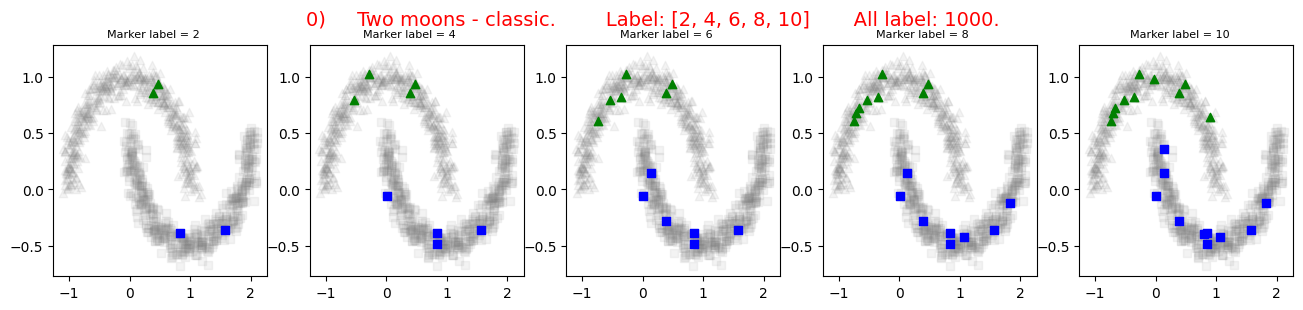

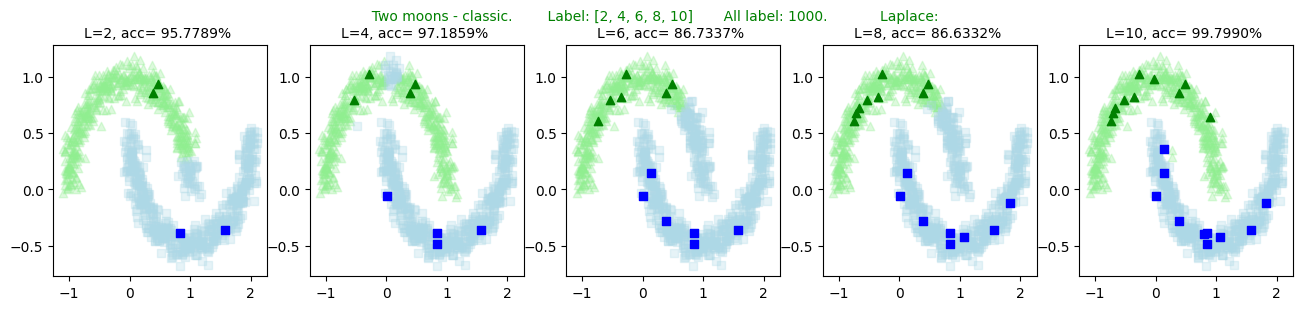

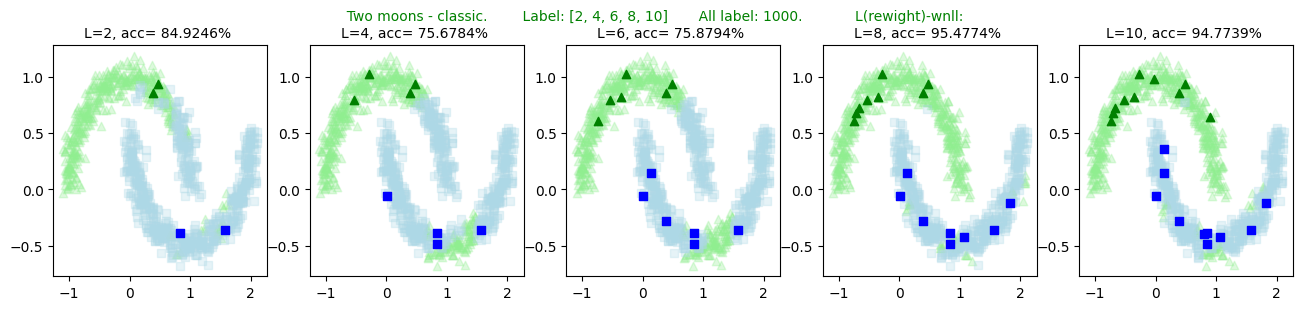

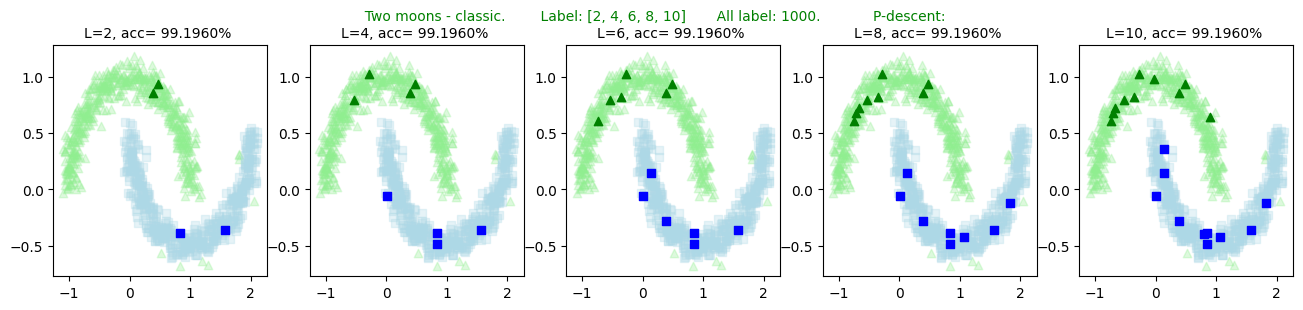

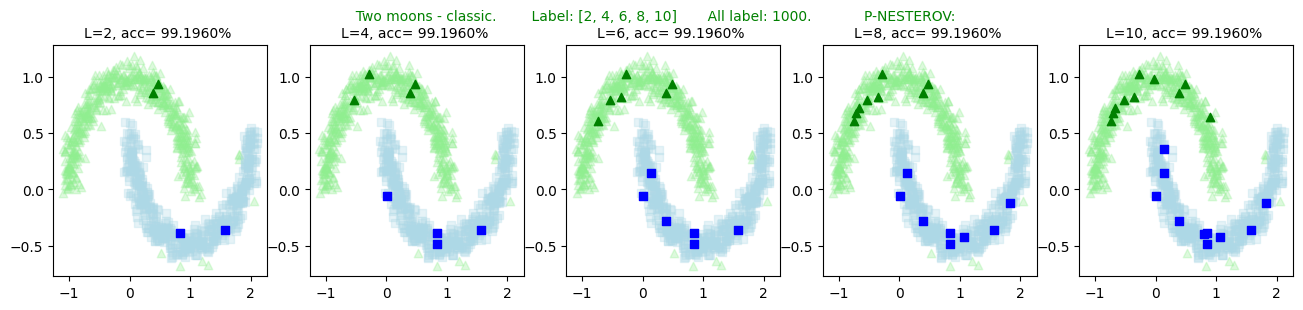

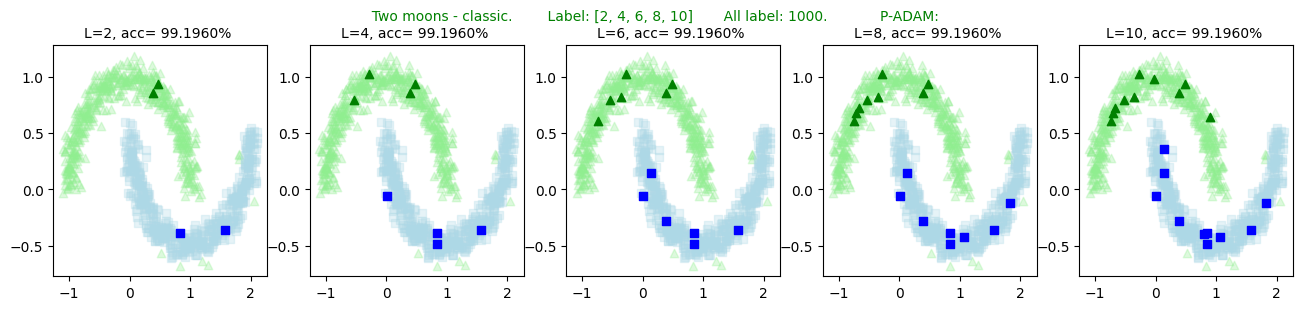

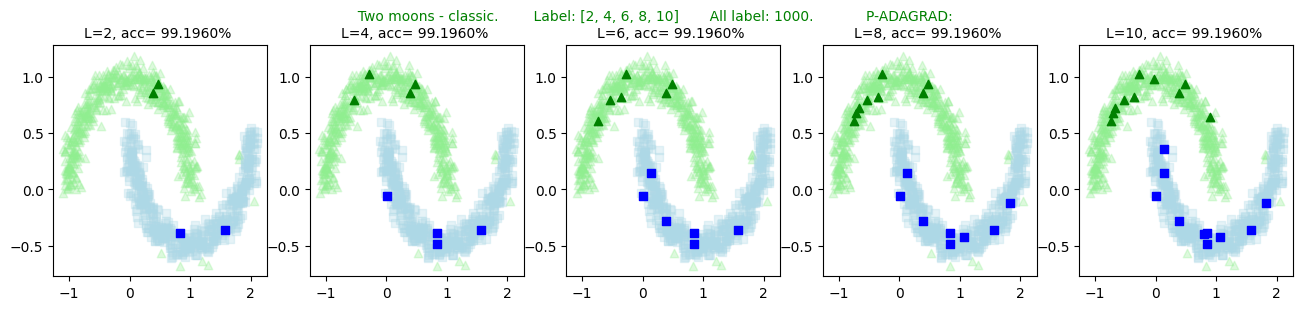

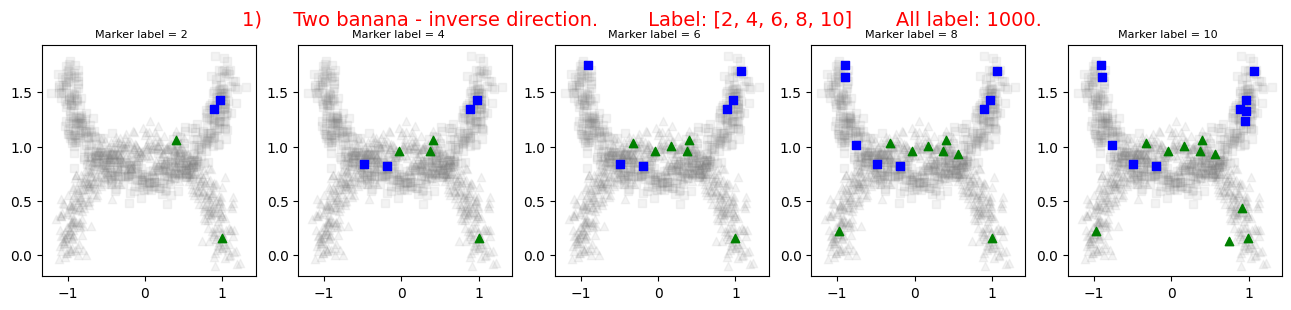

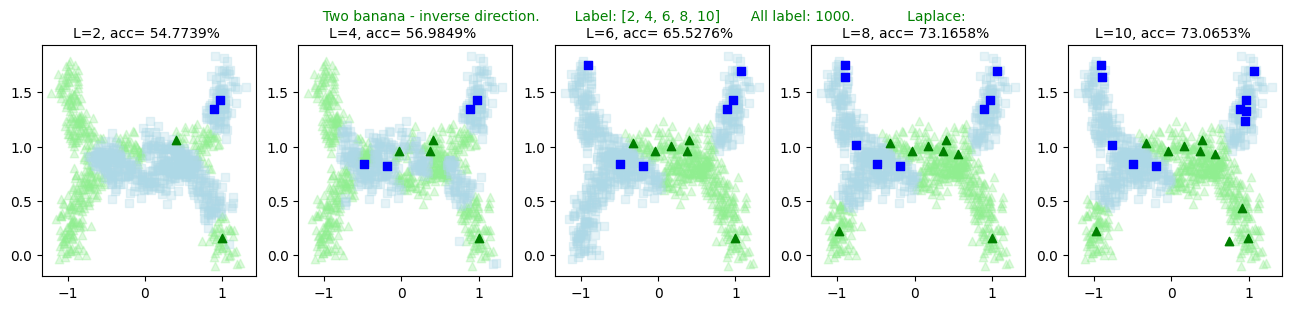

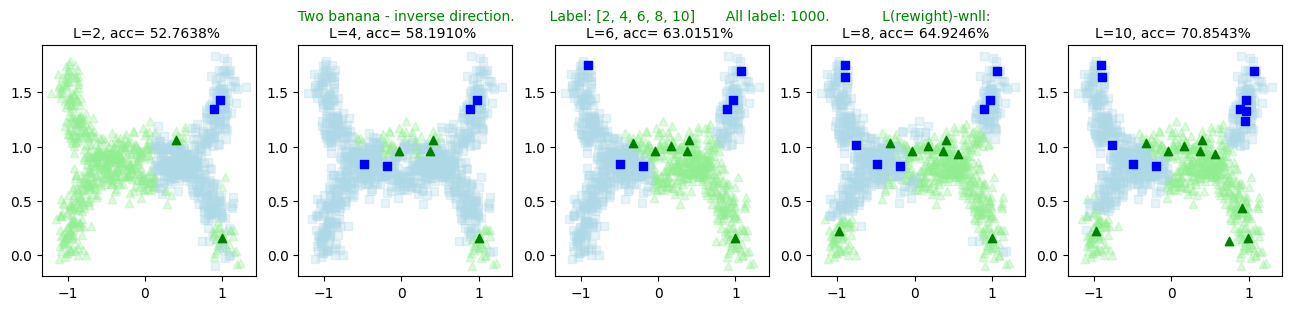

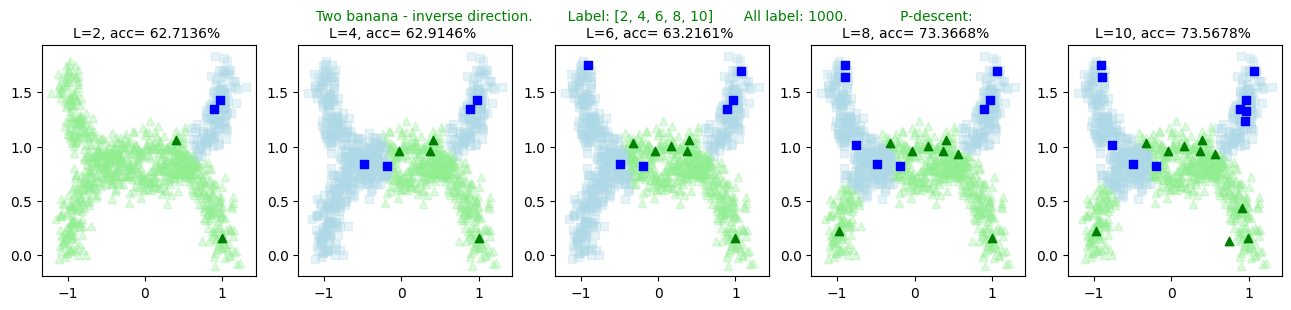

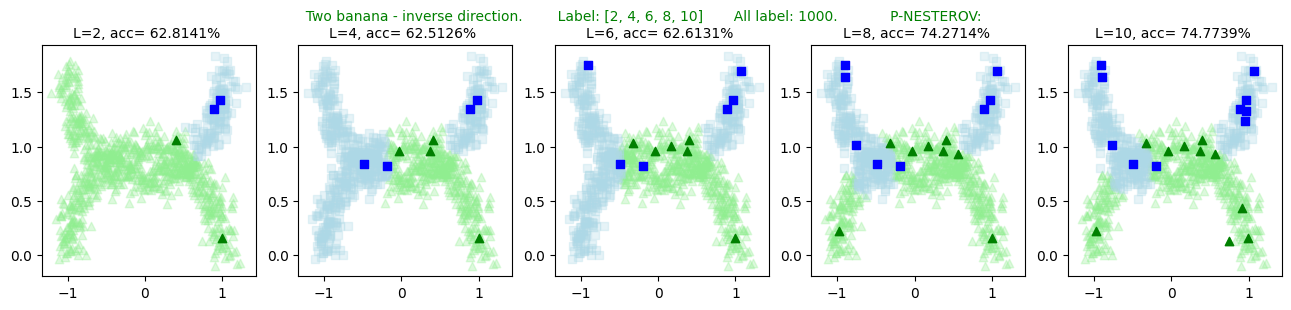

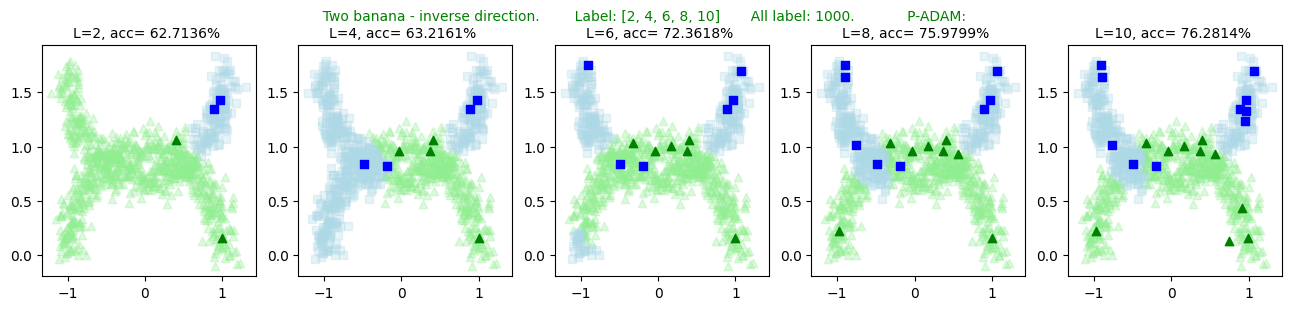

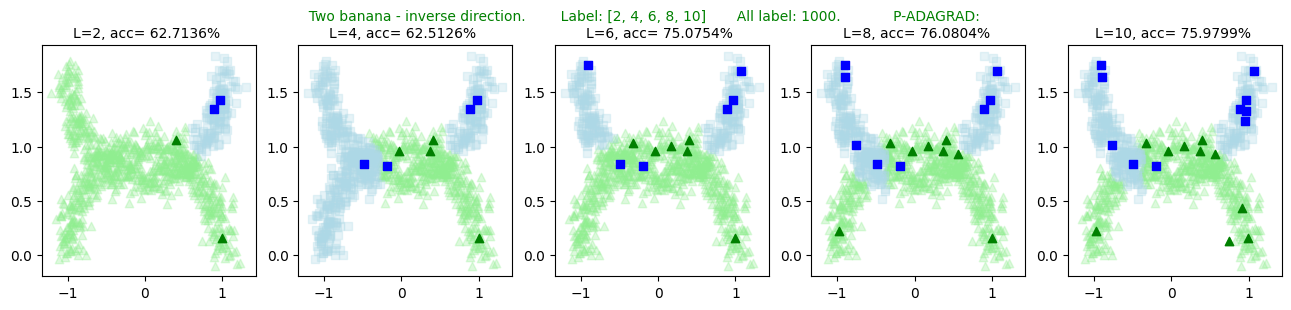

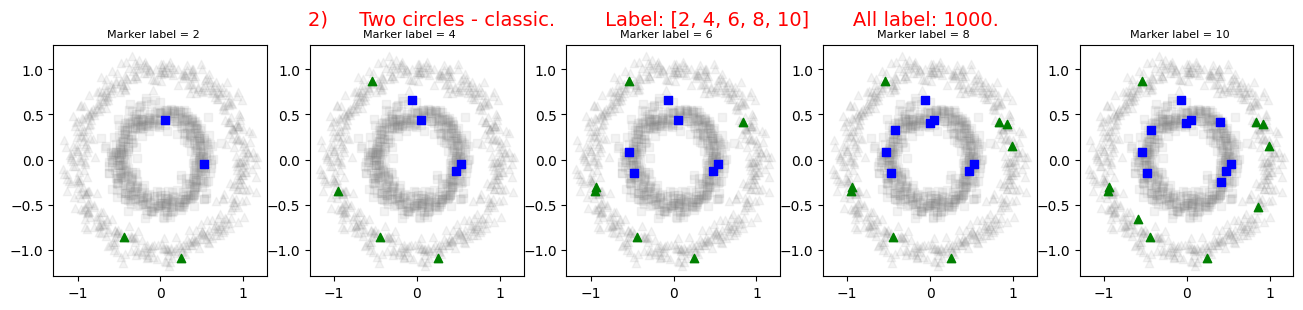

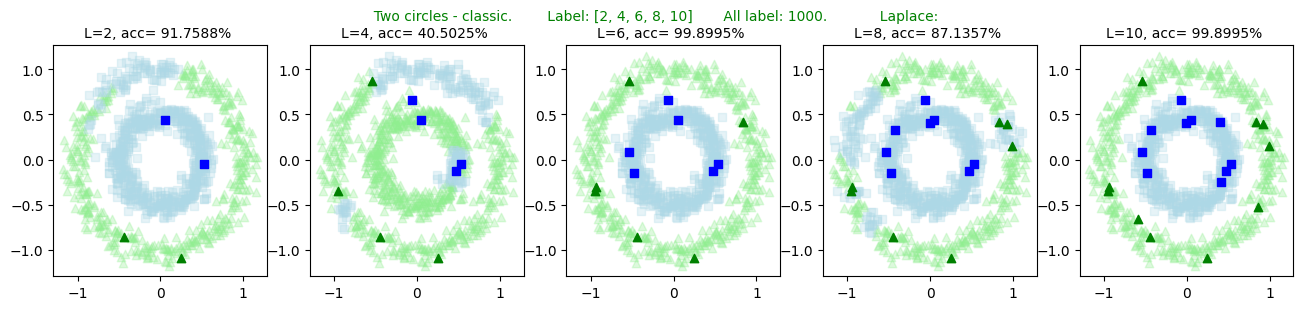

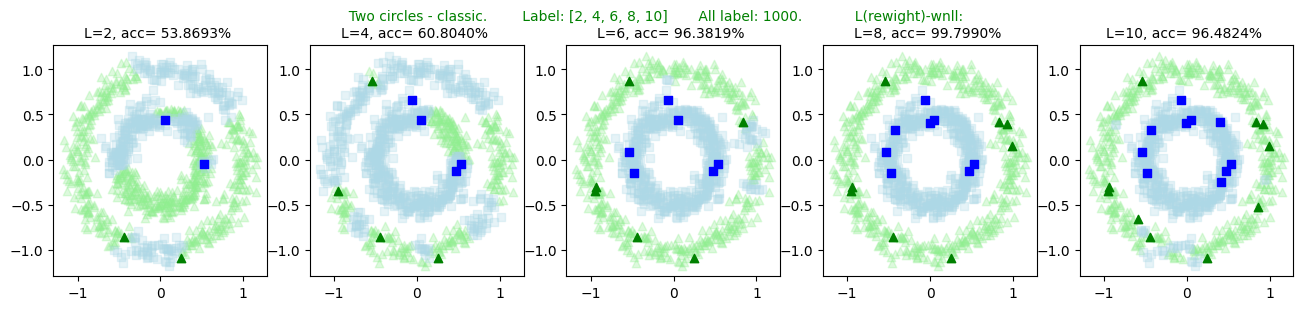

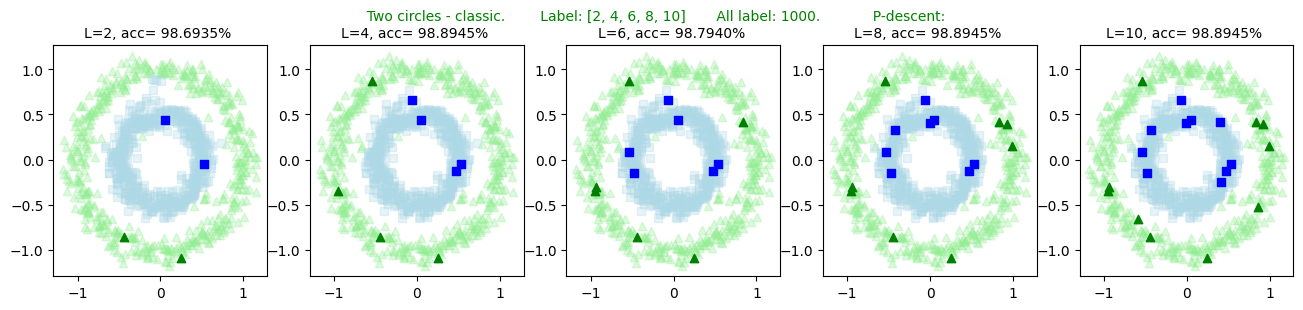

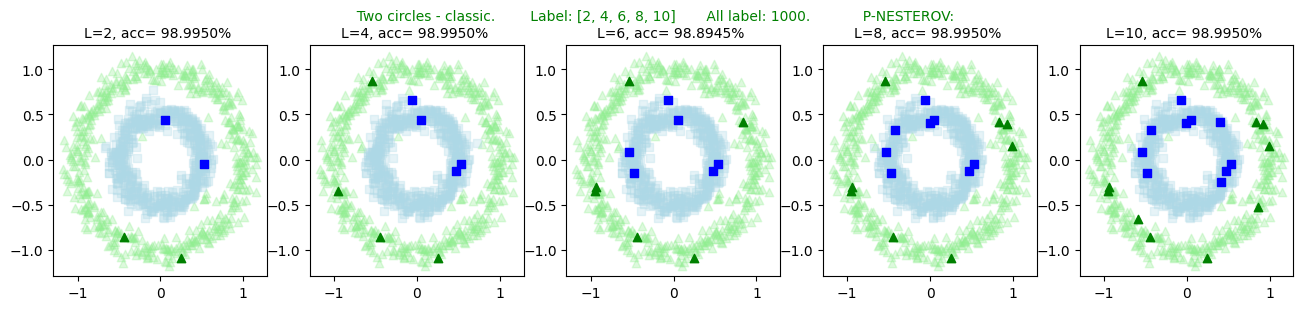

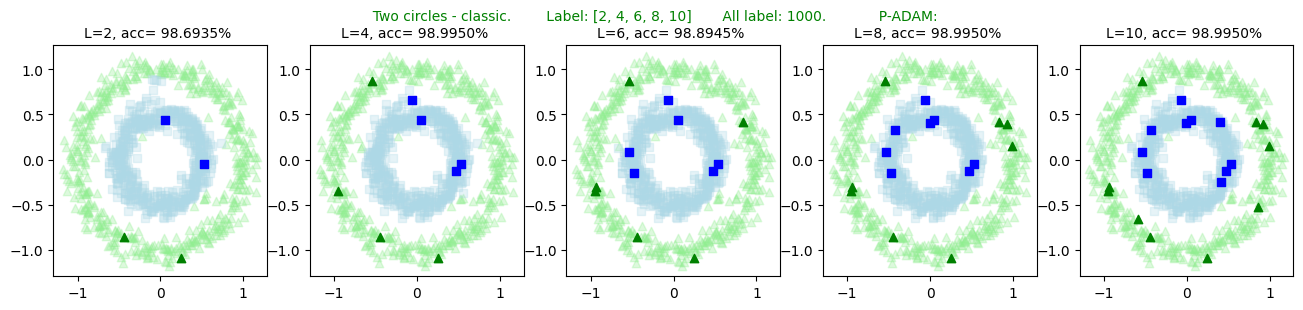

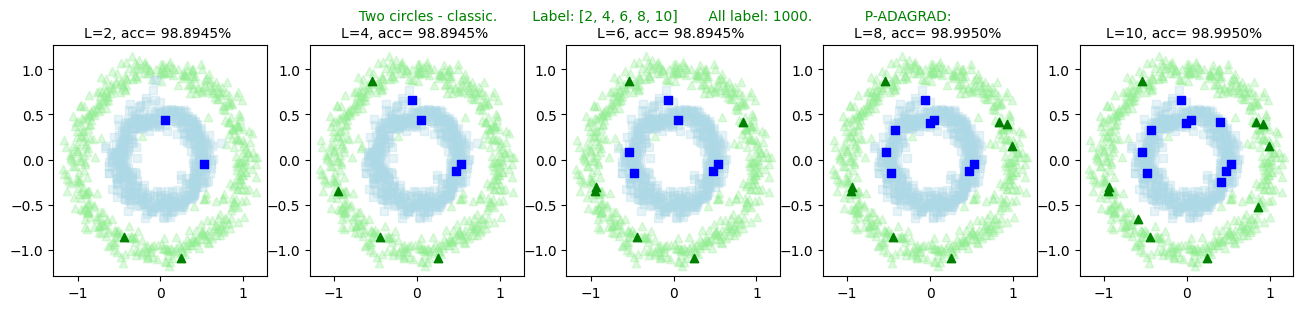

  Two moons - classic
╒═══════════════╤═════════════════╤═════════╤═════════╤═════════╤═════════╤═════════╕
│    mean acc,% │ method\label    │       2 │       4 │       6 │       8 │      10 │
╞═══════════════╪═════════════════╪═════════╪═════════╪═════════╪═════════╪═════════╡
│             0 │ Laplace         │ 93.5343 │ 95.9799 │ 81.675  │ 84.8911 │ 98.5595 │
├───────────────┼─────────────────┼─────────┼─────────┼─────────┼─────────┼─────────┤
│             1 │ L(rewight)-wnll │ 82.4456 │ 78.526  │ 77.0184 │ 78.1575 │ 95.0419 │
├───────────────┼─────────────────┼─────────┼─────────┼─────────┼─────────┼─────────┤
│             2 │ P-descent       │ 99.196  │ 99.196  │ 99.196  │ 99.196  │ 99.196  │
├───────────────┼─────────────────┼─────────┼─────────┼─────────┼─────────┼─────────┤
│             3 │ P-NESTEROV      │ 99.196  │ 99.196  │ 99.196  │ 99.196  │ 99.196  │
├───────────────┼─────────────────┼─────────┼─────────┼─────────┼─────────┼─────────┤
│             4 │ P-ADAM        

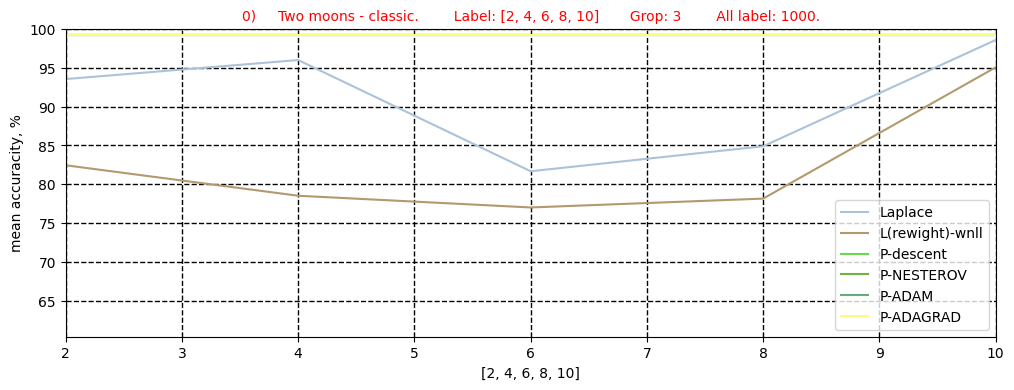

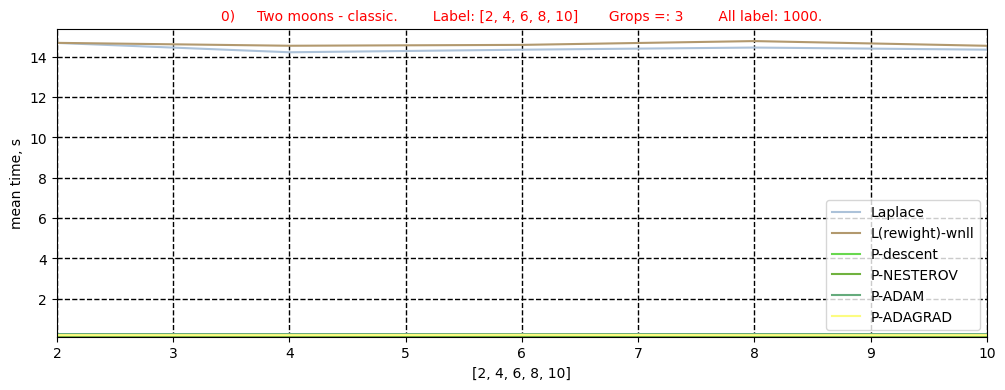

  Two banana - inverse direction
╒═══════════════╤═════════════════╤═════════╤═════════╤═════════╤═════════╤═════════╕
│    mean acc,% │ method\label    │       2 │       4 │       6 │       8 │      10 │
╞═══════════════╪═════════════════╪═════════╪═════════╪═════════╪═════════╪═════════╡
│             0 │ Laplace         │ 50.0838 │ 60.67   │ 75.3434 │ 77.1189 │ 76.9514 │
├───────────────┼─────────────────┼─────────┼─────────┼─────────┼─────────┼─────────┤
│             1 │ L(rewight)-wnll │ 49.6147 │ 62.0436 │ 73.5008 │ 75.5109 │ 76.4824 │
├───────────────┼─────────────────┼─────────┼─────────┼─────────┼─────────┼─────────┤
│             2 │ P-descent       │ 65.0921 │ 72.5963 │ 75.0754 │ 77.5879 │ 77.5209 │
├───────────────┼─────────────────┼─────────┼─────────┼─────────┼─────────┼─────────┤
│             3 │ P-NESTEROV      │ 63.0151 │ 72.5963 │ 72.1608 │ 75.5109 │ 75.5444 │
├───────────────┼─────────────────┼─────────┼─────────┼─────────┼─────────┼─────────┤
│             4 │ P-A

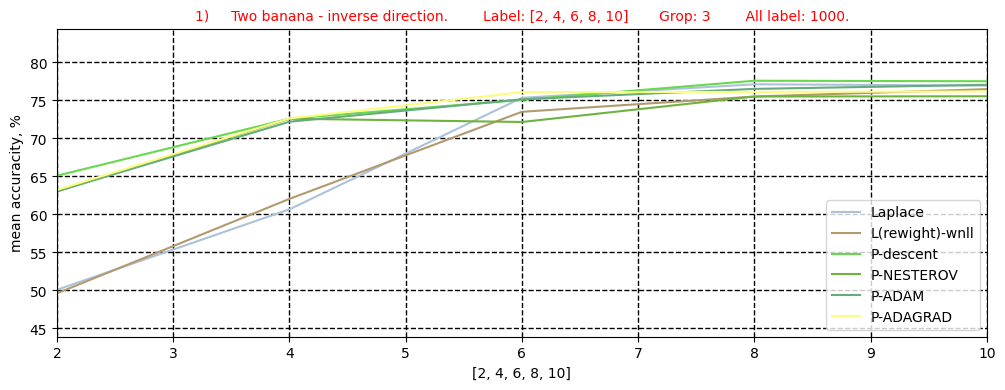

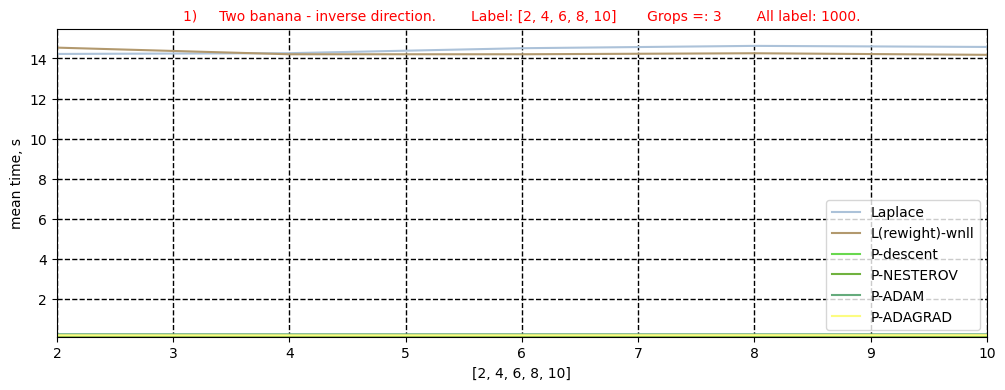

  Two circles - classic
╒═══════════════╤═════════════════╤═════════╤═════════╤═════════╤═════════╤═════════╕
│    mean acc,% │ method\label    │       2 │       4 │       6 │       8 │      10 │
╞═══════════════╪═════════════════╪═════════╪═════════╪═════════╪═════════╪═════════╡
│             0 │ Laplace         │ 83.8861 │ 54.3049 │ 91.3233 │ 87.7052 │ 97.0854 │
├───────────────┼─────────────────┼─────────┼─────────┼─────────┼─────────┼─────────┤
│             1 │ L(rewight)-wnll │ 54.8409 │ 76.0804 │ 89.0787 │ 99.8325 │ 86.3317 │
├───────────────┼─────────────────┼─────────┼─────────┼─────────┼─────────┼─────────┤
│             2 │ P-descent       │ 97.6214 │ 98.8945 │ 98.8275 │ 98.861  │ 99.0285 │
├───────────────┼─────────────────┼─────────┼─────────┼─────────┼─────────┼─────────┤
│             3 │ P-NESTEROV      │ 98.928  │ 98.995  │ 98.928  │ 98.995  │ 99.129  │
├───────────────┼─────────────────┼─────────┼─────────┼─────────┼─────────┼─────────┤
│             4 │ P-ADAM      

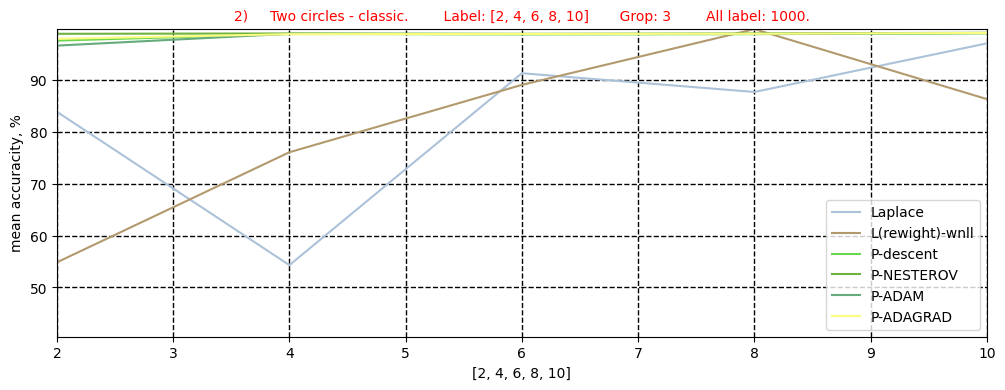

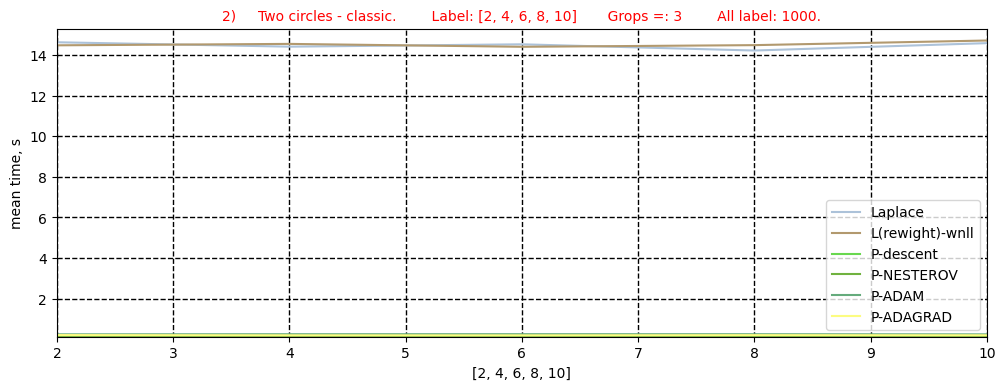

In [11]:
gssl_learning_all_stat(N, example_models_data, example_modelss, example_number_labels,t1,t2,p1,p2,N_group)